References:

* [Step by Step Diabetes Classification-KNN-detailed )](https://www.kaggle.com/code/shrutimechlearn/step-by-step-diabetes-classification-knn-detailed)
- [Compare the effect of different scalers on data with outliers](https://scikit-learn.org/stable/auto_examples/preprocessing/plot_all_scaling.html#plot-all-scaling-minmax-scaler-section)

#Load Data

In [ ]:
from matplotlib import rcParams
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np


In [ ]:
# Load the dataset
df = pd.read_csv('drive/MyDrive/Completumhealth/diabetes/diabetes.csv')

# rename the DiabetesPedigreeFunction column
df.rename(columns ={"DiabetesPedigreeFunction":"DPF"},inplace=True)
feature_names = [cname for cname in df.loc[:,:'Age'].columns]

#Exploratory Data Analysis

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Pregnancies    768 non-null    int64  
 1   Glucose        768 non-null    int64  
 2   BloodPressure  768 non-null    int64  
 3   SkinThickness  768 non-null    int64  
 4   Insulin        768 non-null    int64  
 5   BMI            768 non-null    float64
 6   DPF            768 non-null    float64
 7   Age            768 non-null    int64  
 8   Outcome        768 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 54.1 KB


In [ ]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Pregnancies,768.0,3.845052,3.369578,0.000,1.00000,3.0000,6.00000,17.00
Glucose,768.0,120.894531,31.972618,0.000,99.00000,117.0000,140.25000,199.00
BloodPressure,768.0,69.105469,19.355807,0.000,62.00000,72.0000,80.00000,122.00
SkinThickness,768.0,20.536458,15.952218,0.000,0.00000,23.0000,32.00000,99.00
Insulin,768.0,79.799479,115.244002,0.000,0.00000,30.5000,127.25000,846.00
BMI,768.0,31.992578,7.884160,0.000,27.30000,32.0000,36.60000,67.10
DPF,768.0,0.471876,0.331329,0.078,0.24375,0.3725,0.62625,2.42
Age,768.0,33.240885,11.760232,21.000,24.00000,29.0000,41.00000,81.00
Outcome,768.0,0.348958,0.476951,0.000,0.00000,0.0000,1.00000,1.00


In [ ]:
df.isna().sum()

Pregnancies      0
Glucose          0
BloodPressure    0
SkinThickness    0
Insulin          0
BMI              0
DPF              0
Age              0
Outcome          0
dtype: int64

There are no missing values.

In [ ]:
df.columns

Index(['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin',
       'BMI', 'DPF', 'Age', 'Outcome'],
      dtype='object')

In [ ]:
print('Not Diabetic', round(df['Outcome'].value_counts()[0]/len(df) * 100,2), '% of the dataset')
print('Diabetic', round(df['Outcome'].value_counts()[1]/len(df) * 100,2), '% of the dataset')

Not Diabetic 65.1 % of the dataset
Diabetic 34.9 % of the dataset


Text(0.5, 1.0, 'Class Distributions \n (0: Not Diabetic || 1: Diabetic)')

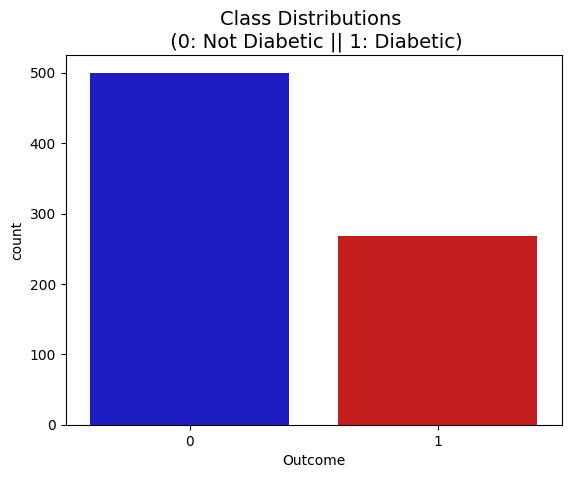

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

colors = ["#0101DF", "#DF0101"]

sns.countplot(x='Outcome', data=df, palette=colors)
plt.title('Class Distributions \n (0: Not Diabetic || 1: Diabetic)', fontsize=14)

The classes are not heavily skewed. We have good representation of diabetic and non-diabetic people.

**Distributions**:

We can observe the distributions of individual columns and determine how skewed are they.

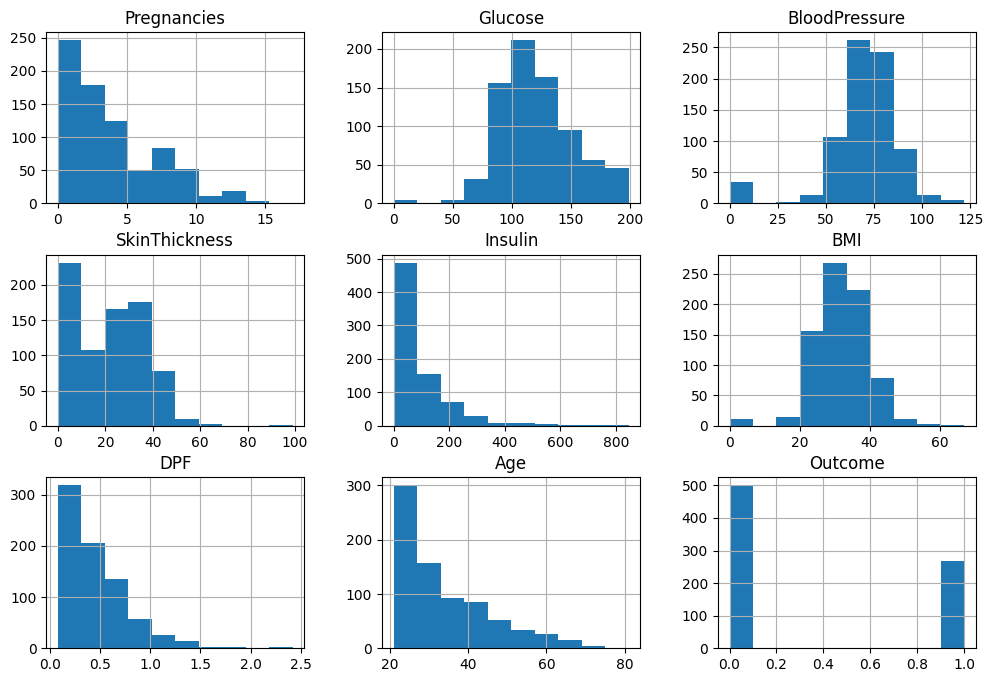

In [ ]:
df.hist(figsize=(12, 8))
plt.show()

**Data Statistics**

In [ ]:
def compute_stat(df):
  # Column names
  columns = ['Feature','Mean', 'Std', 'Skewness','Kurtosis']
  df_stats = pd.DataFrame(columns=columns)

  for column in df.columns:
      mean = df[column].mean()
      std = df[column].std()
      skew = df[column].skew()
      kurtosis = df[column].kurtosis()
      df_stats.loc[len(df_stats)] = [column, mean,std,skew,kurtosis]
      #print(column+':')
      #print('mean: {0:.4f}, std: {1:.4f}, skew: {2:.4f}, kurtosis: {3:.4f} '.format(mean, std, skew, kurtosis))
  return df_stats

df_stats = compute_stat(df)
print(df_stats)

         Feature        Mean         Std  Skewness  Kurtosis
0    Pregnancies    3.845052    3.369578  0.901674  0.159220
1        Glucose  120.894531   31.972618  0.173754  0.640780
2  BloodPressure   69.105469   19.355807 -1.843608  5.180157
3  SkinThickness   20.536458   15.952218  0.109372 -0.520072
4        Insulin   79.799479  115.244002  2.272251  7.214260
5            BMI   31.992578    7.884160 -0.428982  3.290443
6            DPF    0.471876    0.331329  1.919911  5.594954
7            Age   33.240885   11.760232  1.129597  0.643159
8        Outcome    0.348958    0.476951  0.635017 -1.600930


## Skewness and Kurtosis in Data Distributions

**Skewness** and **kurtosis** are statistical measures that provide insights into the shape of a data distribution. Understanding their effects can guide data transformation decisions, especially for models assuming normally distributed errors.

### Skewness

- **Definition**: Skewness gauges the distribution's asymmetry. A distribution is:
  - Left-skewed if the value is negative.
  - Right-skewed if positive.
  - Symmetric if close to zero.
  
#### Impact of Skewness in Classification

In classification, skewness can refer to the distribution of feature values or the distribution of class labels. The implications of skewness in each context are:

#### 1. Feature Skewness

- **Nature of Algorithms**: Some algorithms, particularly parametric ones like logistic regression or linear discriminant analysis, assume specific distributions for feature values. Skewed distributions can violate these assumptions and potentially degrade model performance.
  
- **Scale and Distribution**: Algorithms sensitive to feature scale and distribution, such as k-nearest neighbors (due to its distance-based nature) and neural networks (due to gradient descent dynamics), can be affected by skewed features. Transformations to address skewness can be beneficial in these cases.
  
- **Interpretability**: For some algorithms like tree-based methods (e.g., decision trees, random forests), the skewness of features might not directly impact performance. However, reducing skewness can enhance feature interpretability and ensure consistent data preprocessing.

#### 2. Class Label Skewness (Class Imbalance)

- **Performance Metrics**: In scenarios with significant class imbalance, accuracy might not be a reliable metric. For example, with 95% of instances in Class A and 5% in Class B, a naive model predicting only Class A would have a 95% accuracy but might not be genuinely useful.
  
- **Model Bias**: Models can become biased towards the majority class, leading to poor recall for the minority class. This bias is especially problematic in contexts like fraud detection, where detecting the minority class (frauds) is crucial.
  
- **Mitigation Strategies**: Addressing class imbalance can involve techniques like oversampling the minority class, undersampling the majority class, generating synthetic data using methods like SMOTE, or adjusting class weights in the algorithm.

In conclusion, skewness can play a pivotal role in classification tasks, depending on the specific algorithm and context. Being cognizant of skewness and its potential impacts is essential for informed model development and evaluation.




### Kurtosis

- **Definition**: Kurtosis evaluates the "tailedness" of a distribution. Compared to a normal distribution (with a kurtosis of 3):
  - High kurtosis indicates heavier tails, implying more outliers.
  - Low kurtosis suggests lighter tails.
  - "Excess kurtosis" is often mentioned, calculated as kurtosis minus 3.
  
- **Impact**: High kurtosis can be an issue for models assuming normally distributed errors due to the presence of more outliers.

### Impact of Kurtosis in Classification

Kurtosis is a statistical measure that describes the "tailedness" of a distribution. In the context of classification, kurtosis can pertain to the distribution of feature values. Let's delve into the implications:

### 1. Feature Kurtosis

- **Heavy Tails & Outliers**: High kurtosis indicates that the distribution has heavier tails than a normal distribution. This suggests a higher likelihood of outliers. Outliers can particularly influence algorithms sensitive to extreme values, like SVM with certain kernels or linear models.

- **Light Tails**: Low kurtosis suggests the distribution has lighter tails than a normal distribution, implying fewer extreme values or outliers.

- **Algorithm Implications**: While tree-based algorithms (e.g., decision trees, random forests) are generally robust to outliers, linear models and distance-based algorithms (like k-nearest neighbors) can be significantly influenced by them. High kurtosis might be a sign to investigate potential outliers or extreme values that could adversely affect such models.

- **Transformations**: For distributions with high kurtosis and discernible outliers, transformations (like log, Box-Cox, or Yeo-Johnson) or robust scaling methods can help in mitigating the effect of outliers and make the data more amenable to certain algorithms.

### 2. Class Label Kurtosis

- **Relevance**: Kurtosis typically applies to continuous data distributions. In classification, class labels are categorical, so kurtosis isn't directly applicable. However, the concept of having extreme values or rare categories can be analogously considered, leading to concerns of class imbalance.

In conclusion, while kurtosis itself might not be a primary concern in classification, the implications of high kurtosis—especially the presence of outliers—can be essential. Recognizing and addressing the effects of extreme feature values can be pivotal for the success of various classification algorithms.


### Tolerable Value Range

- **Skewness**:
  - Between -0.5 and 0.5: fairly symmetrical.
  - Between -1 and -0.5 (or 0.5 and 1): moderate skewness.
  - Outside -1 and 1: high skewness.

- **Kurtosis** (Excess Kurtosis):
  - Close to 0: similar to a normal distribution.
  - Greater than 0: more outliers than a normal distribution.
  - Less than 0: fewer outliers than a normal distribution.

### Caveats

- While these ranges serve as guidelines, they aren't hard rules. Skewness and kurtosis's effect varies depending on the model and application.
- Visualization tools like histograms, Q-Q plots, or P-P plots offer more insights into distribution.
- Not all algorithms mandate normally distributed data. For instance, tree-based algorithms often don't.

### Addressing Skewness and Kurtosis

- Transformations like logarithmic, square root, Box-Cox, or Yeo-Johnson can mitigate skewness and kurtosis.
- Detecting and handling outliers can particularly help when high kurtosis stems from extreme values.

Remember: While skewness and kurtosis offer valuable insights, actions should be dictated by the specific algorithm needs, problem context, and the model's empirical performance on validation data.


In [ ]:
def kurtosis_warning(val):
  if -0.5 < val < 0.5:
    color = "green"
  if val > .5:
    color = 'blue'
  if val < -.5:
    color = "cyan"
  return f'color: {color}'

def skew_warning(val):
  if -0.5 < val < 0.5:
    color = "green"
  if -1 < val < -0.5 or 0.5 < val < 1:
    color = 'yellow'
  if val < -1 or val > 1:
    color = "red"
  return f'color: {color}'

df_styled = (df_stats.style.applymap(skew_warning, subset=['Skewness']).applymap(kurtosis_warning, subset=['Kurtosis']))
df_styled

,Feature,Mean,Std,Skewness,Kurtosis
0,Pregnancies,3.845052,3.369578,0.901674,0.159220
1,Glucose,120.894531,31.972618,0.173754,0.640780
2,BloodPressure,69.105469,19.355807,-1.843608,5.180157
3,SkinThickness,20.536458,15.952218,0.109372,-0.520072
4,Insulin,79.799479,115.244002,2.272251,7.214260
5,BMI,31.992578,7.884160,-0.428982,3.290443
6,DPF,0.471876,0.331329,1.919911,5.594954
7,Age,33.240885,11.760232,1.129597,0.643159
8,Outcome,0.348958,0.476951,0.635017,-1.600930


For Skewness:
* <font color="green">Green</font>: Fairly symmetrical.
* <font color="yellow">Yellow</font>: Moderate skewness.
* <font color="red">Red</font>: High skewness.

For Kurtosis:
* <font color="green">Green</font>: Similar to a normal distribution.
* <font color="blue">Blue</font>: More outliers than a normal distribution.
* <font color="cyan">Cyan</font>: Fewer outliers than a normal distribution.

**Note**: Removing outliers of columns would help the ML model to better learn the features and their correlation. It should be done contextually and should not entail in removing outliers blindly from all columns.

## Correlation

### Importance of Correlation Matrix in Binary Classification

The correlation matrix, visualized as a heatmap, quantifies the linear relationships between pairs of features. In binary classification, understanding these relationships offers several advantages:

- Feature Selection
  - Multicollinearity: Features with high inter-correlations can introduce instability in certain algorithms. Recognizing and handling these can improve model robustness.
  - Redundancy: Highly correlated features may carry redundant information. Removing one can reduce dimensionality without significant loss of information.

- Feature Engineering Insights
  - Highly correlated features can hint at opportunities for new feature creation, potentially enhancing predictive power.

- Detecting Data Issues
 - Unexpected correlations can signal data problems, like leakage, where a predictor inadvertently contains information about the target.

- Understanding the Target
 - Examining each feature's correlation with the target provides an initial gauge of its potential predictive importance.

- Algorithmic Efficiency
 - Some algorithms benefit from feature independence. Identifying and handling correlated features can improve performance.

**Points to Remember**:
- Nature of Correlation: Pearson correlation measures linear relationships. Non-linear relationships may need other methods for detection.
- Correlation ≠ Causation: A correlation doesn't imply a causal relationship.
- Binary Features: For binary features in binary classification, consider using point-biserial correlation.

In essence, while invaluable, the correlation matrix is among many tools used in data preprocessing for binary classification.


In [ ]:
df.corr()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DPF,Age,Outcome
Pregnancies,1.000000,0.129459,0.141282,-0.081672,-0.073535,0.017683,-0.033523,0.544341,0.221898
Glucose,0.129459,1.000000,0.152590,0.057328,0.331357,0.221071,0.137337,0.263514,0.466581
BloodPressure,0.141282,0.152590,1.000000,0.207371,0.088933,0.281805,0.041265,0.239528,0.065068
SkinThickness,-0.081672,0.057328,0.207371,1.000000,0.436783,0.392573,0.183928,-0.113970,0.074752
Insulin,-0.073535,0.331357,0.088933,0.436783,1.000000,0.197859,0.185071,-0.042163,0.130548
BMI,0.017683,0.221071,0.281805,0.392573,0.197859,1.000000,0.140647,0.036242,0.292695
DPF,-0.033523,0.137337,0.041265,0.183928,0.185071,0.140647,1.000000,0.033561,0.173844
Age,0.544341,0.263514,0.239528,-0.113970,-0.042163,0.036242,0.033561,1.000000,0.238356
Outcome,0.221898,0.466581,0.065068,0.074752,0.130548,0.292695,0.173844,0.238356,1.000000


###Pair Plots or Scatter Matrix:

To visualize pair-wise relationships and histograms for multiple numerical variables.

### Pair Plots (Scatter Matrices)

A pair plot, often referred to as a scatter matrix in certain tools, is a matrix layout of scatter plots, showcasing the relationship between two variables. This visualization offers a comprehensive depiction of pairwise relationships and distributions in a dataset.

### Key Insights from Pair Plots:

1. **Relationships between Variables**: The off-diagonal subplots depict scatter plots for two distinct variables for discerning linear or non-linear correlations, anomalies, or clusters.

2. **Distribution of Individual Variables**: Diagonal plots (often histograms or Kernel Density Estimates in tools like seaborn) display the distribution of individual variables.

3. **Comparison Across Classes**: Categorical variable (Outcome), allow coloring by class using the `hue` parameter. This helps in observing how different classes exhibit clustering behavior across features.

4. **Visual Correlation Indication**: Though scatter plots don't provide quantitative correlation values, visible patterns can hint at potential correlations.

5. **Spotting Outliers**: Outliers or anomalies might become evident through scatter plots.

### Points to Consider:

- **Dimensionality**: With numerous features, pair plots can become cluttered and less intuitive.
- **Overplotting**: With large datasets, overplotting can occur where data points overlap, obscuring distribution. Techniques like point transparency, hexbin plots, or 2D KDE plots can help.
- **Applicability**: These plots are ideal for numeric data and aren't tailored for categorical variables. However, categorically coloring data points can enhance insights.

In essence, during the exploratory data analysis phase, pair plots serve as invaluable tools for gleaning insights and guiding further feature engineering or analysis.


<Figure size 1000x800 with 0 Axes>

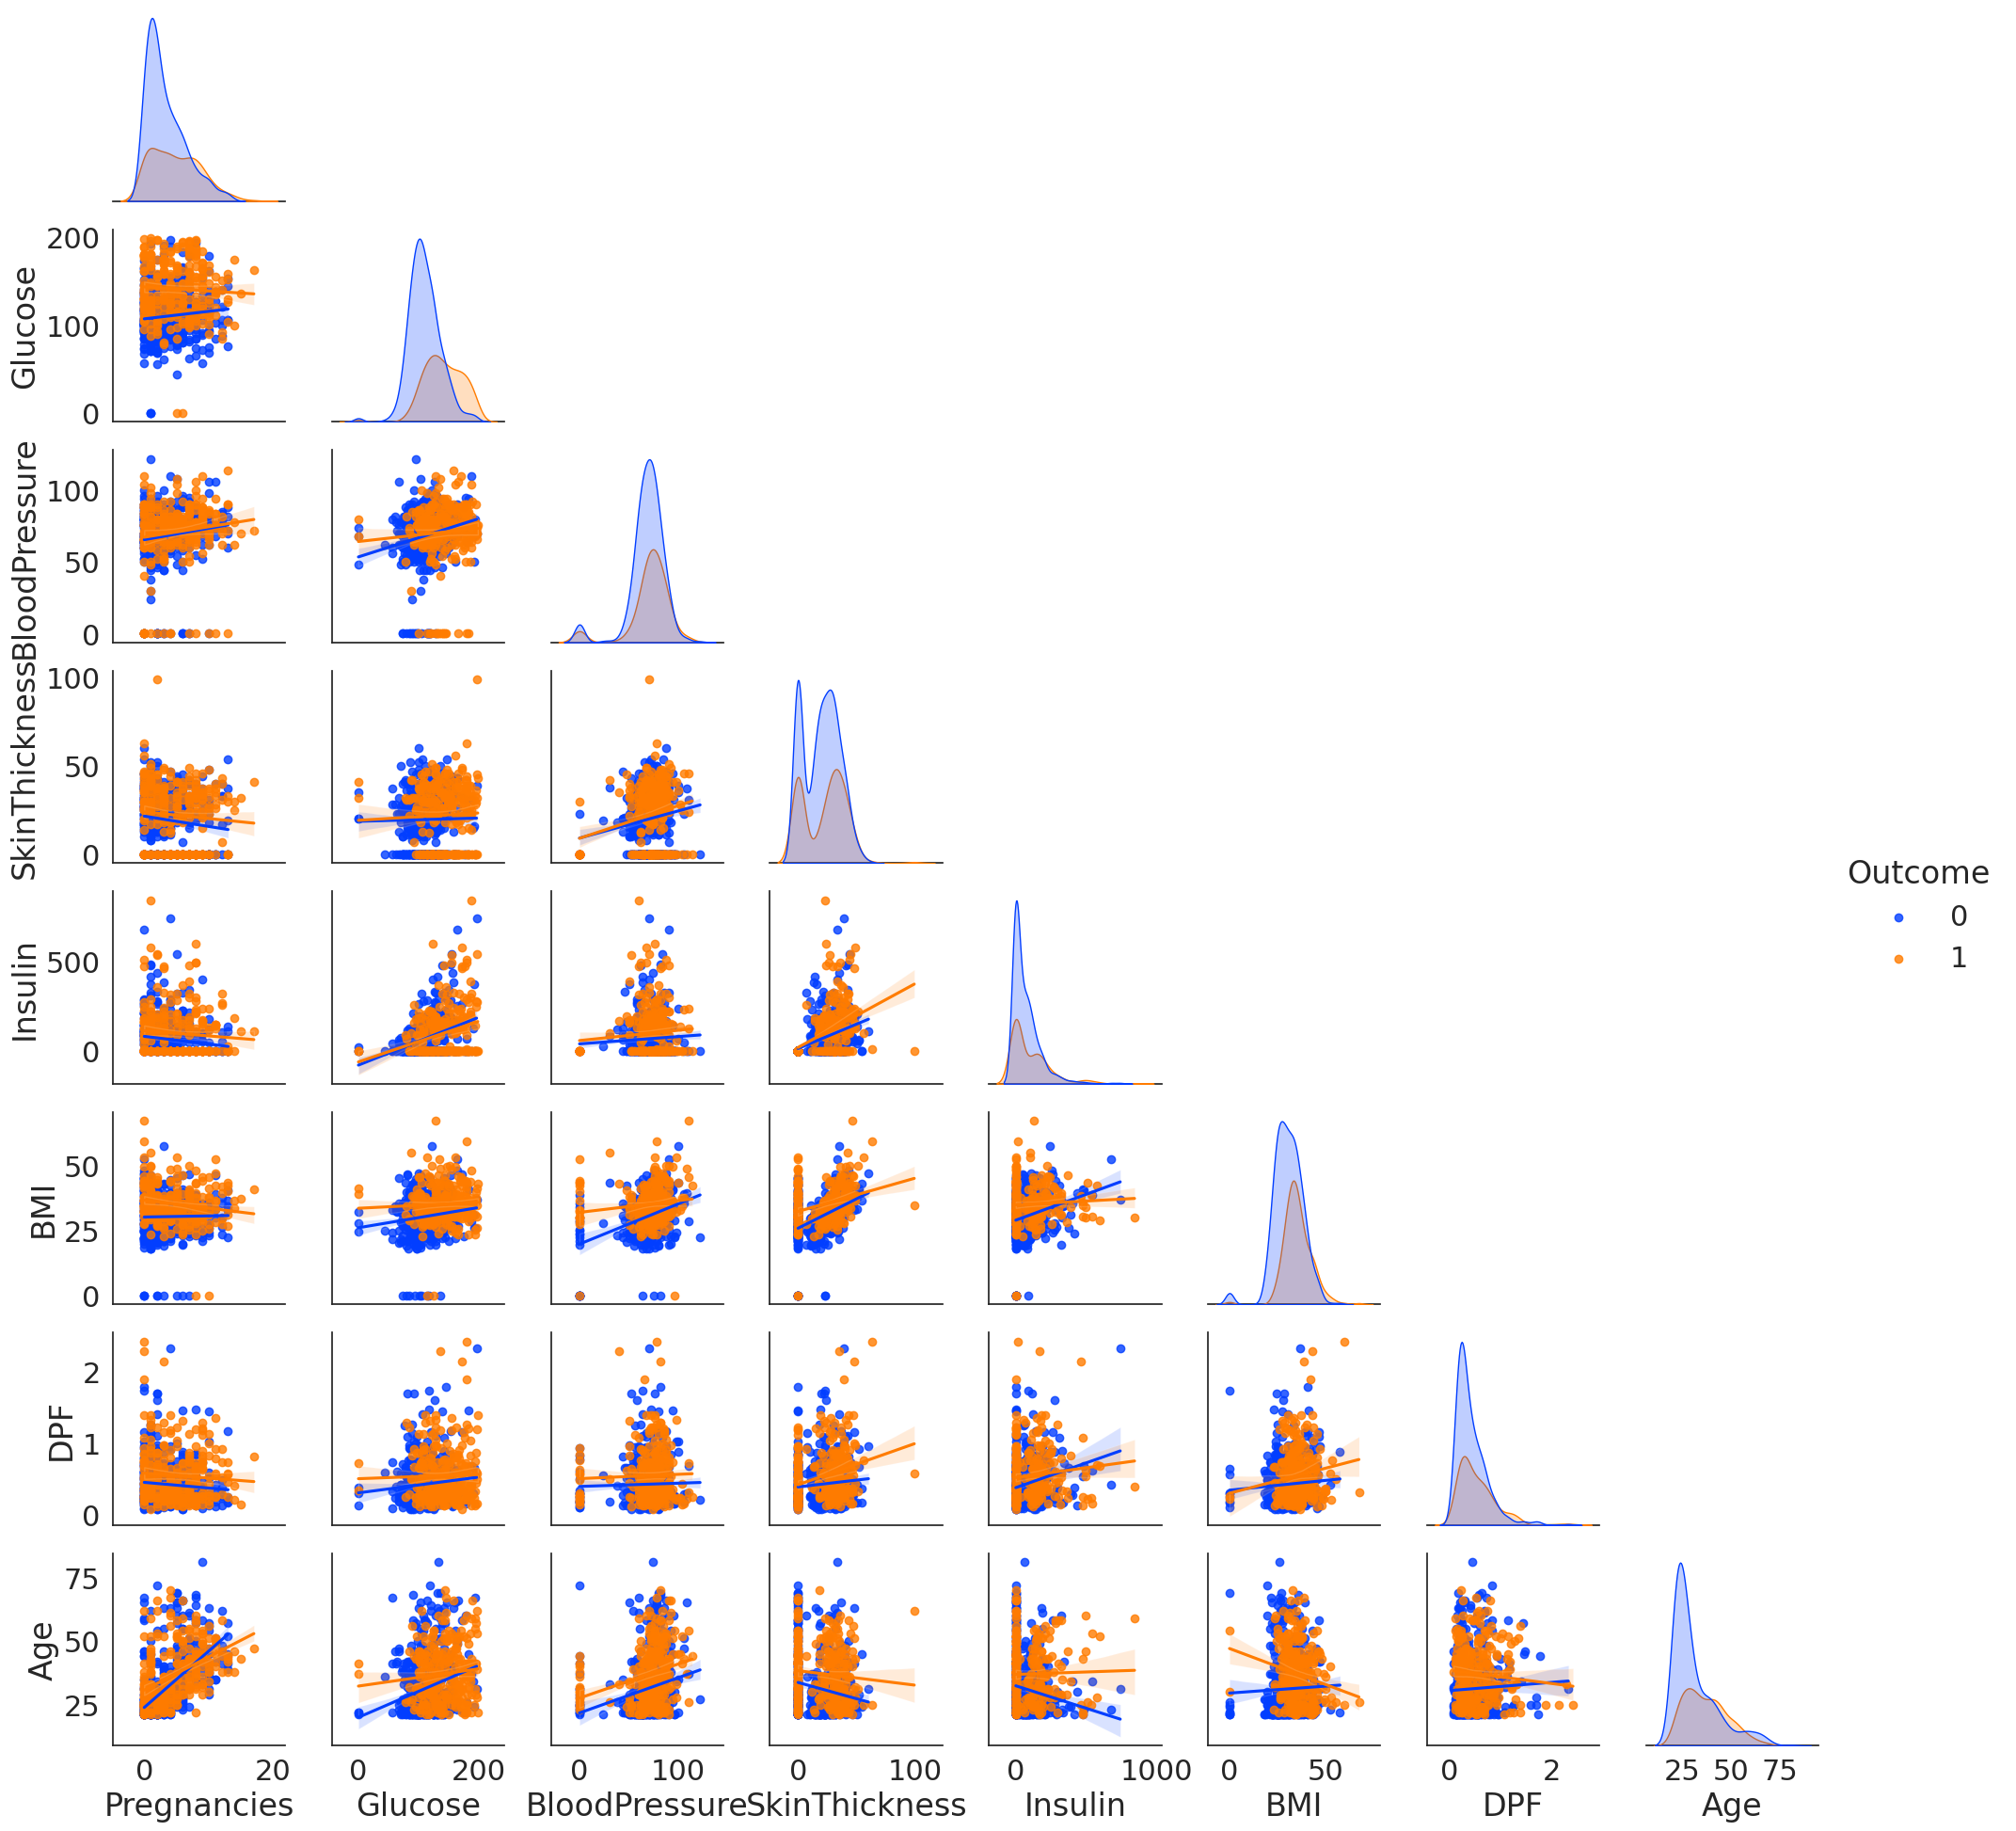

In [ ]:
import seaborn as sns
#sns.pairplot(df)

sns.set(font_scale=2)
plt.figure(figsize=(10, 8))
sns.set_style("white")
sns.set_palette("bright")
sns.pairplot(df,kind = 'reg',corner = True,hue="Outcome")


###Heatmaps

To visualize the correlation matrix.

Text(0.5, 1.0, 'Correlation Plot')

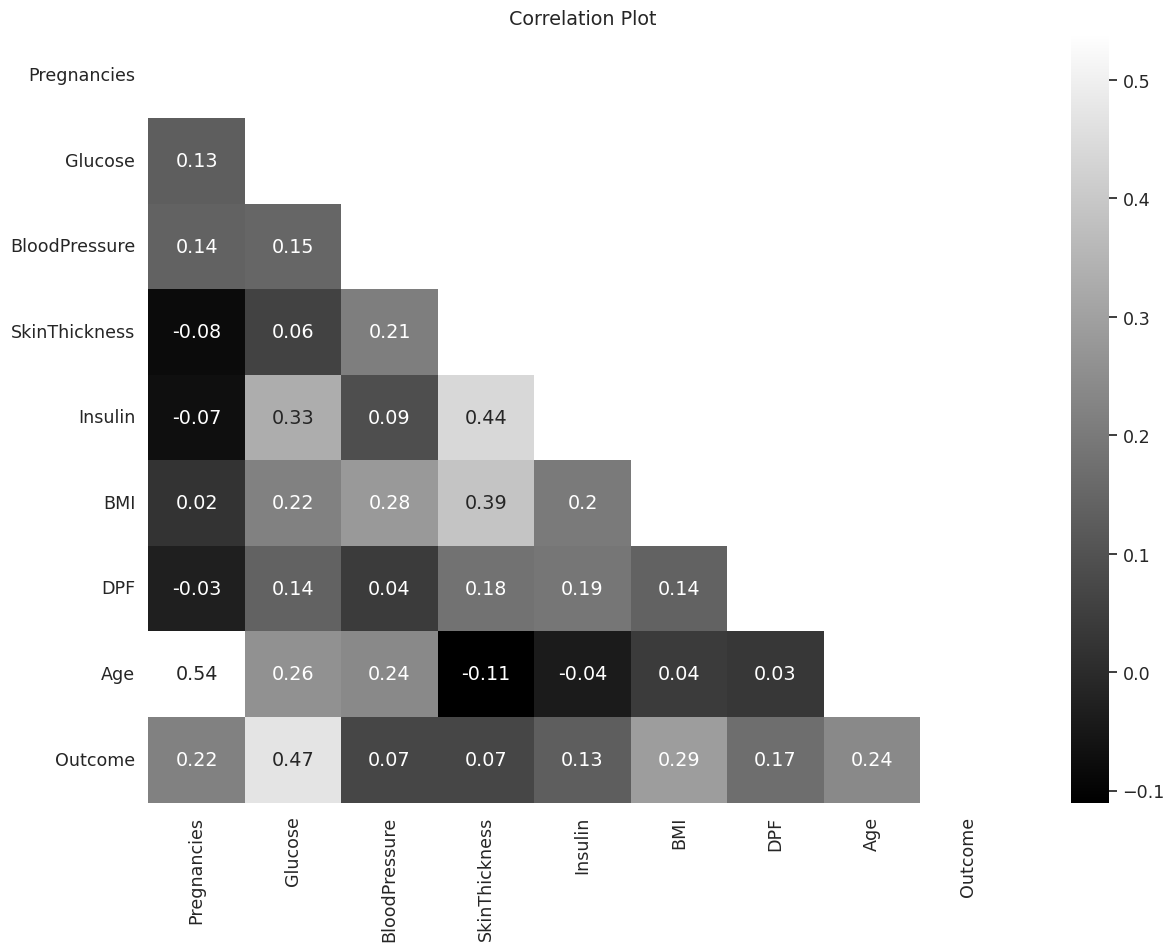

In [ ]:
#sns.heatmap(df.corr())

corr=df.corr().round(2)

sns.set(font_scale=1.15)
plt.figure(figsize=(14, 10))
sns.set_palette("bright")
sns.set_style("white")
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)] = True
sns.heatmap(corr,annot=True,cmap='gist_yarg_r',mask=mask,cbar=True)
plt.title('Correlation Plot')

In [ ]:
df.columns

Index(['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin',
       'BMI', 'DPF', 'Age', 'Outcome'],
      dtype='object')

Consider the last row or the last column of the correlation matrix which shows the correlation of outcome to other features. It is indicative that the outcome is directly correlated to Pregnancies, Glucose, Insulin, BMI, DPF and Age.

##Box Plots

To identify outliers and understand the spread of data.

A box plot, also known as a box-and-whisker plot, is a graphical representation of a dataset's five-number summary: the minimum, first quartile (Q1), median (Q2 or second quartile), third quartile (Q3), and maximum. It provides a visual summary of the data's distribution, spread, skewness, and the presence of outliers. Here's a detailed breakdown of what a box plot tells us:

**Components of a Box Plot**

1. **Box**: The central box represents the interquartile range (IQR), which is the range between the first quartile (25th percentile) and the third quartile (75th percentile).

2. **Whiskers**: The lines extending from the box, known as whiskers, indicate variability outside the IQR. They can either represent a specific percentile or extend to the minimum or maximum data values that are not considered outliers.

  * whis : float or (float, float), default: 1.5
  
    The position of the whiskers. If a float, the lower whisker is at the lowest datum above Q1 - whis*(Q3-Q1), and the upper whisker at the highest datum below Q3 + whis*(Q3-Q1), where Q1 and Q3 are the first and third quartiles.

    The default value of whis = 1.5 corresponds to Tukey's original definition of boxplots.

3. **Median Line**: A line within the box marks the median of the data.

4. **Outliers**: Data points that fall far from the other data points may be plotted individually and are considered outliers.

**What It Tells Us**

1. Central Tendency: The line inside the box shows the median of the dataset, providing an idea of the dataset's central tendency.

2. Variability/Spread: The length of the box (IQR) and whiskers indicate the spread of the data. A longer box or whiskers suggest higher variability, while shorter ones imply lower variability.

3. Symmetry and Skewness:

  * If median is centrally located within box, data is roughly symmetrical.
  * If median is closer to bottom of the box, data is positively skewed.
  * If median is closer to the top, data is negatively skewed.

4. Outliers: Points that are plotted individually outside the whiskers are potential outliers. These can indicate anomalies or errors in the data.

5. Comparison Across Groups: When multiple box plots are displayed side-by-side, you can compare the distributions of different groups easily. This is useful for observing relationships between a numerical variable and a categorical variable.

6. Detection of Anomalies: Extremely long or uneven whiskers, or an asymmetric box, can indicate potential issues with the data collection process or the presence of extreme values affecting the data distribution.

7. Quantiles: The quartiles (Q1 and Q3) provide additional information on data distribution. For instance, if Q1 is closer to the median than Q3, it indicates that the lower half of the dataset is more condensed compared to the upper half.

8. Tail Length: The length of the whiskers can indicate the "heaviness" of the tails in the distribution. Long whiskers suggest long tails, and short whiskers suggest short tails.

In summary, a box plot is a powerful tool for quickly visualizing complex datasets, providing insights into the data's shape, variability, central tendency, and outliers.

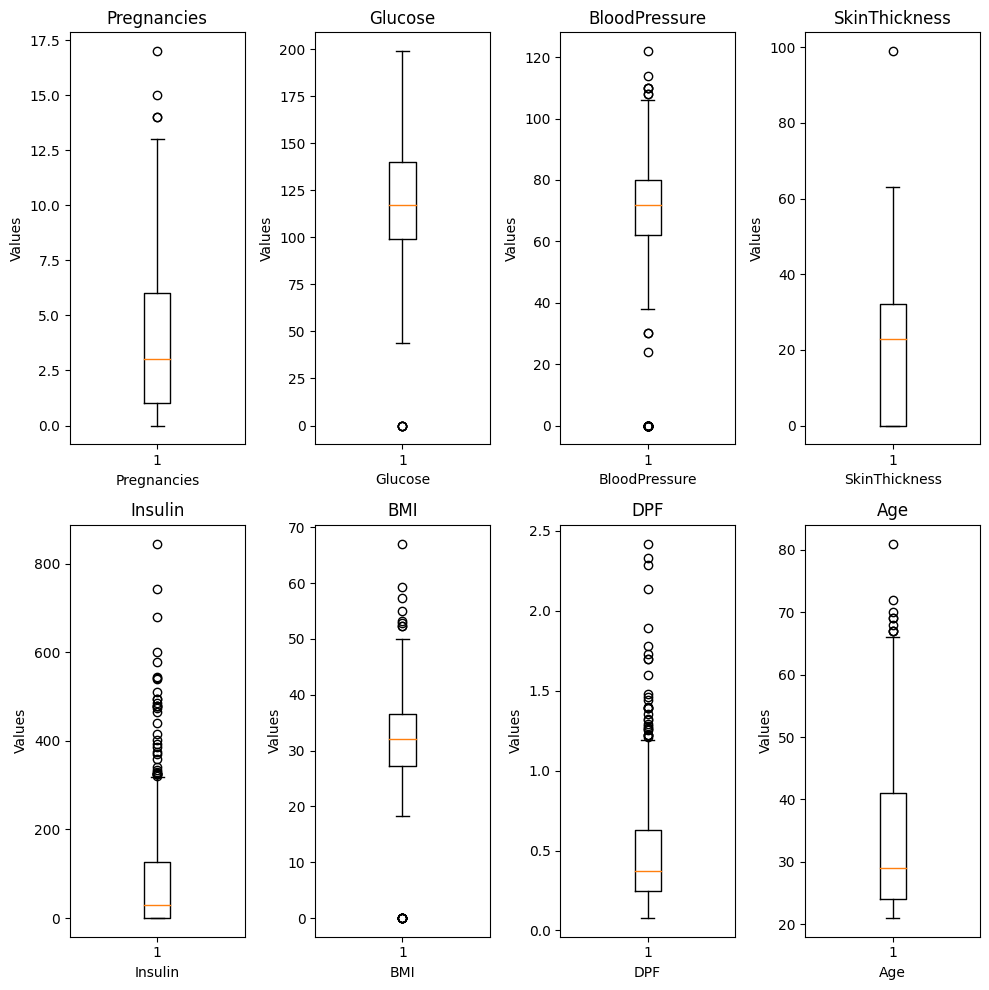

In [ ]:
import numpy as np

# Number of columns and rows for the subplot array
n_cols = 4
n_rows = int(np.ceil( (len(df.columns)-1) / n_cols))
# Create a figure and an array of subplots with 2 rows
fig, ax = plt.subplots(n_rows, n_cols, figsize=(10, 10))

# Flatten the array of subplots if necessary
ax = ax.flatten()

# Loop through each column and each subplot
for i, column in enumerate(df.columns):
    if column == "Outcome":
      continue
    ax[i].boxplot(df[column])  # Create the boxplot
    ax[i].set_title(f"{column}")  # Set the title
    ax[i].set_xlabel(column)  # Set the x-axis label
    ax[i].set_ylabel('Values')  # Set the y-axis label

# Remove any unused subplots
for i in range(len(df.columns), n_cols * n_rows):
    fig.delaxes(ax[i])

plt.tight_layout()  # Adjust layout to prevent overlap
plt.show()  # Show the plot

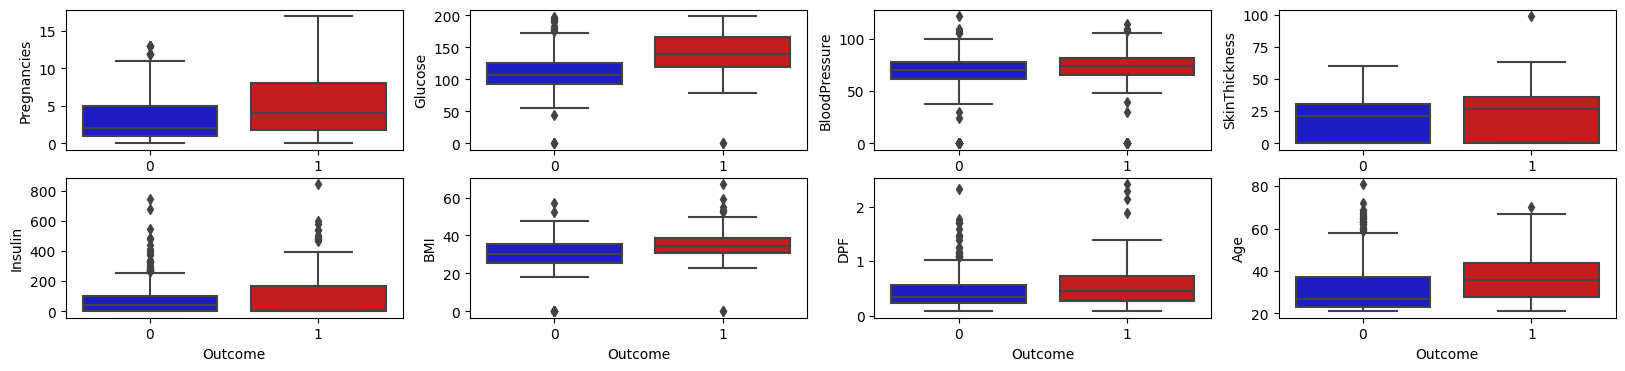

In [ ]:
f, axes = plt.subplots(nrows=2,ncols=4, figsize=(20,4))

for i,column in enumerate(df.columns):
  if column != 'Outcome':
    sns.boxplot(x="Outcome", y=column, data=df, palette=colors, ax=axes[int(i/4),i%4])

#Handling zero/missing values

One common approach to replace zero/missing values is with either mean or median of the respective column.

## Mean Imputation:

- Use when data is normally or approximately normally distributed.
- Be cautious if data has outliers, as it is sensitive to extreme values.
- Often used for continuous variables with missing data.

## Median Imputation:

- When data is skewed or contains outliers.
- Median is robust to outliers.
- Provides better estimate of central tendency when data is not normally distributed.
- Safer choice when dealing with data containing extreme values.

## Other Imputation Techniques:

- Advanced imputation techniques include regression imputation, k-nearest neighbors imputation, and multiple imputation. These methods can consider relationships between variables and may provide more accurate imputations.
- Use these techniques for complex datasets with missing data where simple mean or median imputation might not suffice.

## Removing Rows or Columns:

- Consider removing an entire column if it has a significant portion of missing data and is not critical for your analysis.
- Remove entire rows if they have many missing values and you believe they don't contain valuable information.

## Domain-Specific Strategies:

- In some domains, domain-specific strategies for handling missing data might be available. For example, in time-series data, you can use forward-fill or backward-fill methods.

## Machine Learning Methods:

- Some machine learning algorithms can handle missing data internally, such as decision trees or random forests. In such cases, manual imputation may not be necessary.

## Missing Data Indicators:

- In certain situations, creating a new binary column to indicate whether a value was missing in the original data can be valuable. This preserves information about the missingness and allows the model to account for it.

The choice of imputation method should consider statistical analysis, domain knowledge, and the dataset's characteristics. It's essential to document and justify your imputation strategy in your data analysis report to ensure transparency and reproducibility.


Logically zero values do not make sense for most of the columns, they are effectively missing values. We shall replace the zero values with the mean or median values based on the distribution of data for the coressponding columns.  

Logically, pregnancies can be 0 hence we will not replace these zeros.

In [ ]:
# check proportion of zeros
zero_features = ['Glucose','BloodPressure','SkinThickness',"Insulin",'BMI']
total_count = df.shape[0]

print("Proportion of Zeros:")
for feature in zero_features:
    zero_count = df[df[feature]==0].shape[0]
    pcent = zero_count/total_count * 100
    print('{0}: {1}, {2:.2f}%'.format(feature, zero_count, pcent))

Proportion of Zeros:
Glucose: 5, 0.65%
BloodPressure: 35, 4.56%
SkinThickness: 227, 29.56%
Insulin: 374, 48.70%
BMI: 11, 1.43%


In [ ]:
# glucose is approximately normally distributed
mean = df["Glucose"].mean()
df["Glucose"].replace(0, mean, inplace=True)

# BloodPressure is approximately normally distributed
mean = df["BloodPressure"].mean()
df["BloodPressure"].replace(0, mean, inplace=True)

# SkinThickness is not normally distributed
median = df["SkinThickness"].median()
df["SkinThickness"].replace(0, median, inplace=True)

# Insulin is not normally distributed
median = df["Insulin"].median()
df["Insulin"].replace(0, median, inplace=True)

# BMI is approximately normally distributed
mean = df["BMI"].mean()
df["BMI"].replace(0, mean, inplace=True)



In [ ]:
def histplot(df):
  rcParams['figure.figsize'] = 40,60
  sns.set(font_scale = 3)
  sns.set_style("white")
  sns.set_palette("bright")
  plt.subplots_adjust(hspace=0.5)
  i = 1;
  for name in feature_names:
      plt.subplot(5,2,i)
      sns.histplot(data=df, x=name, hue="Outcome",kde=True,palette="YlGnBu")
      i = i + 1

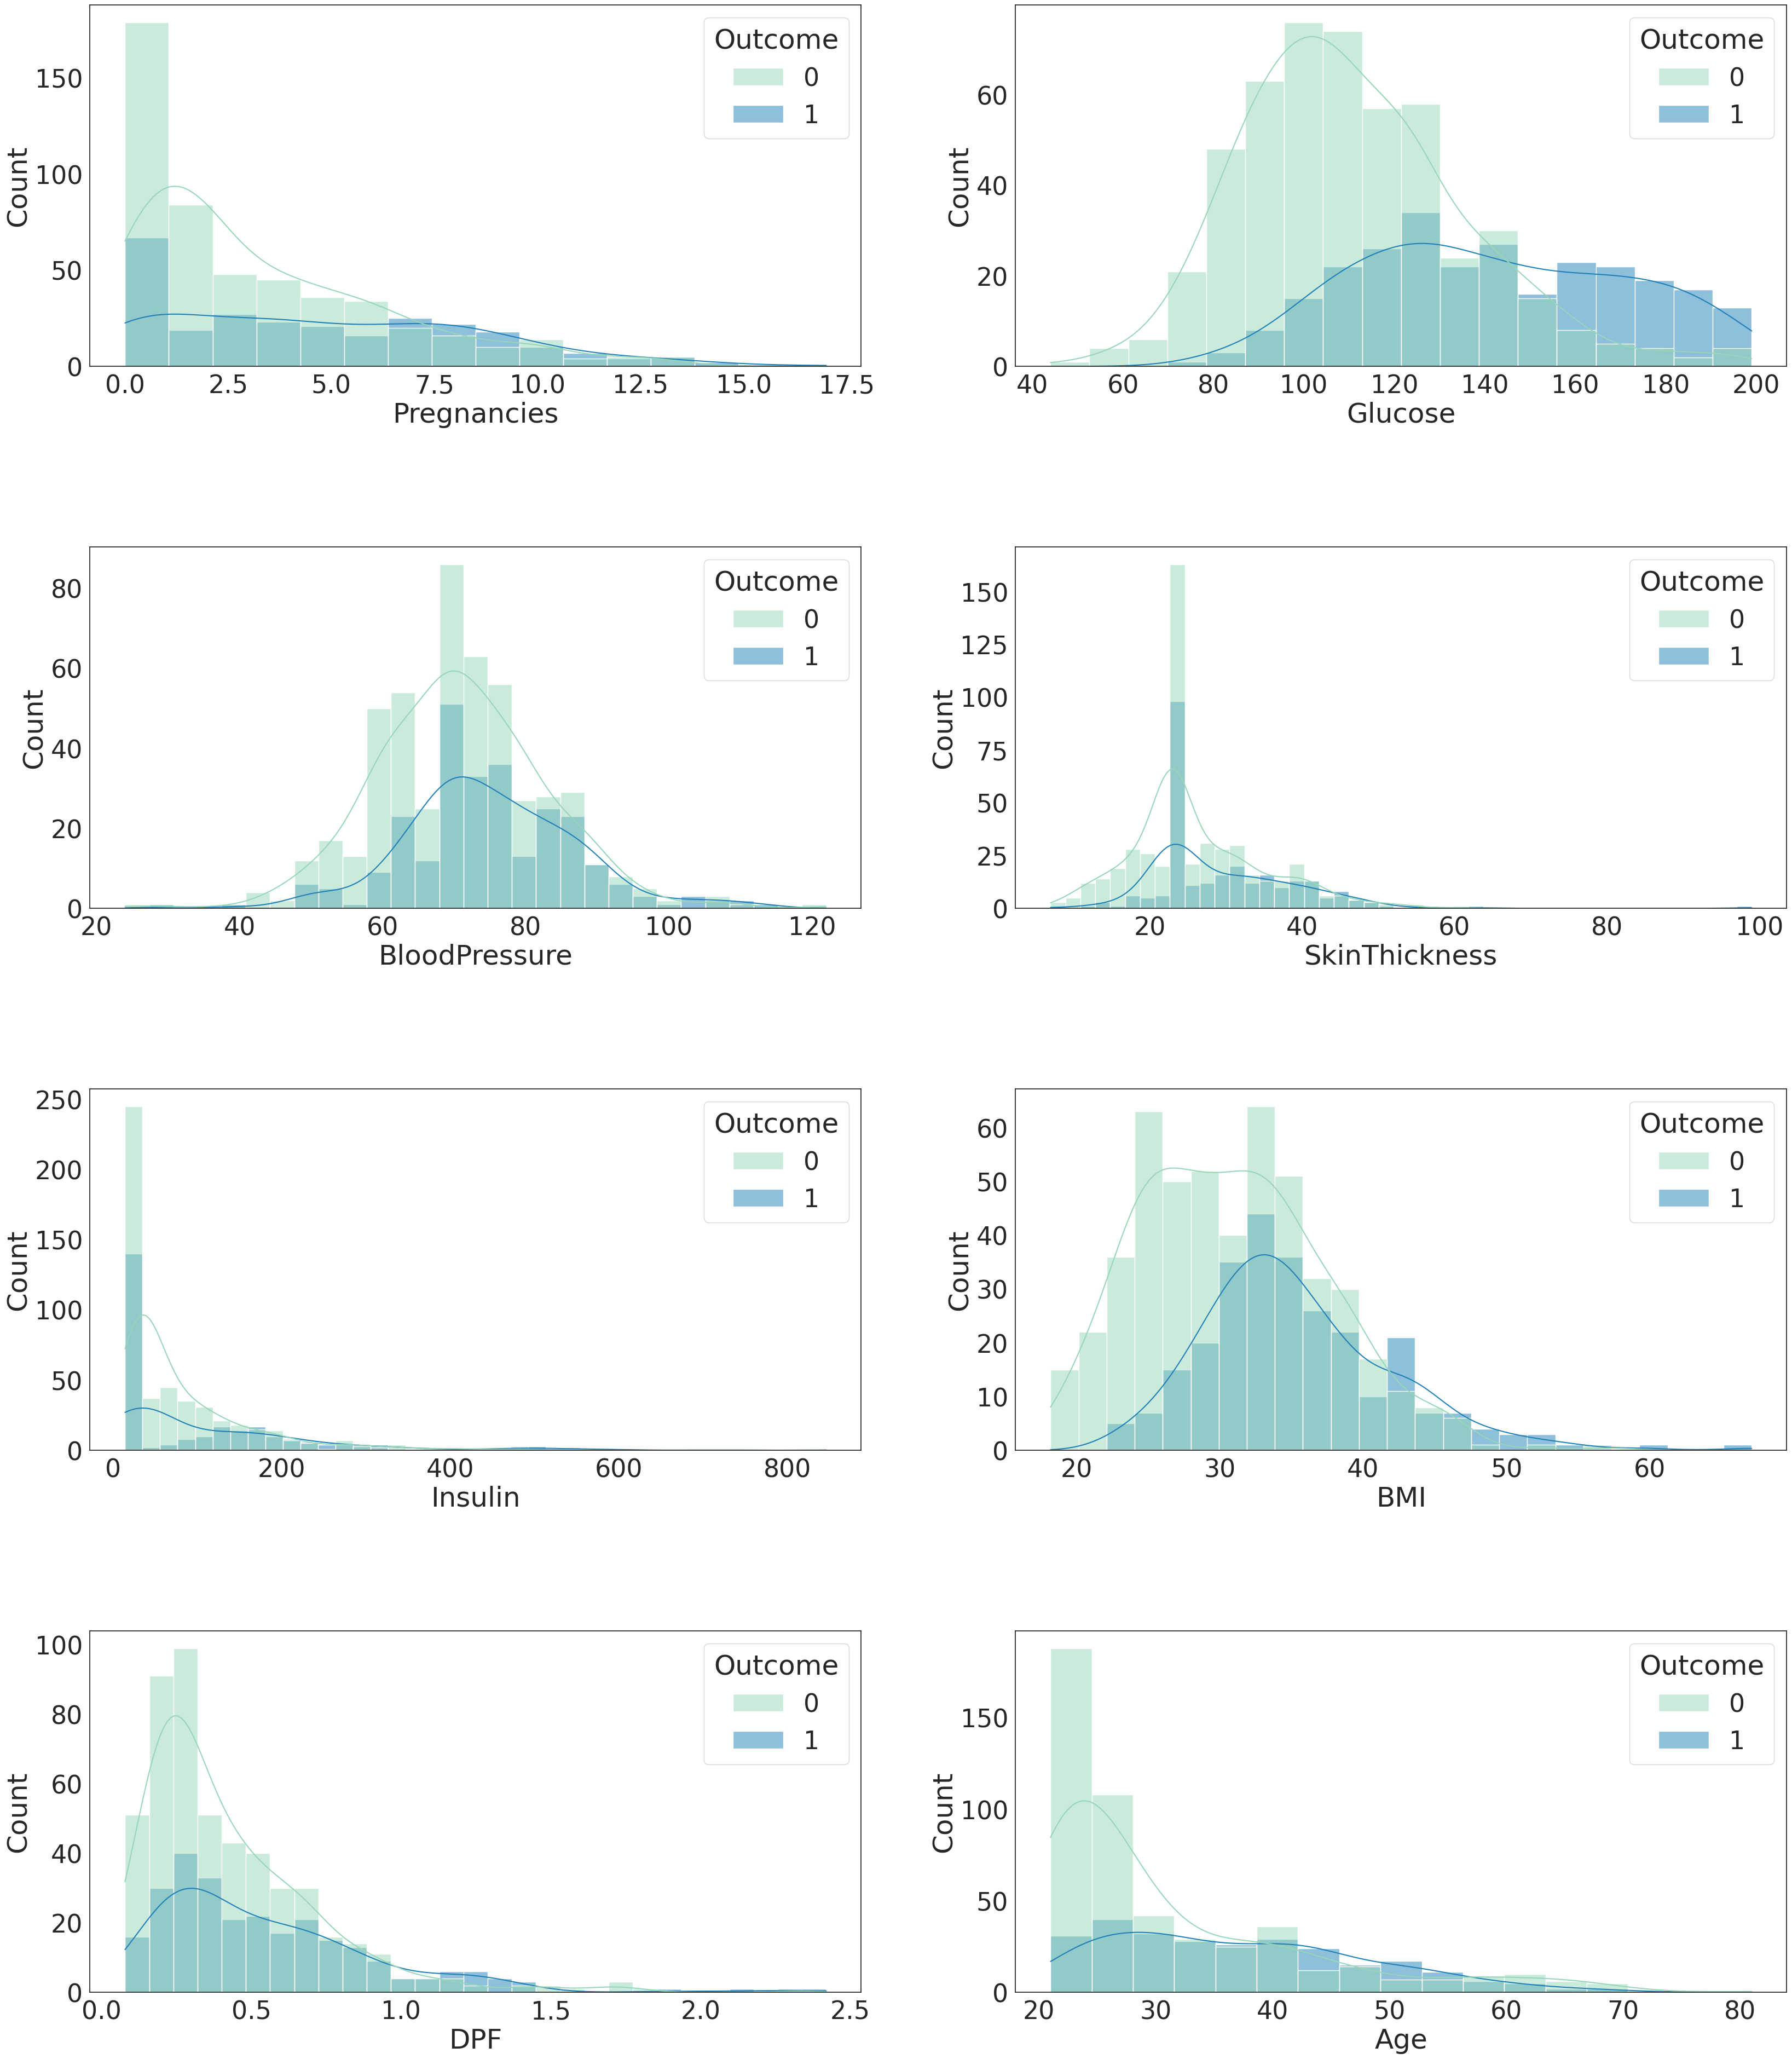

In [ ]:
histplot(df)

In [ ]:
df_stats2 = compute_stat(df)
df_styled2 = (df_stats2.style.applymap(skew_warning, subset=['Skewness']).applymap(kurtosis_warning, subset=['Kurtosis']))
df_styled2

,Feature,Mean,Std,Skewness,Kurtosis
0,Pregnancies,3.845052,3.369578,0.901674,0.159220
1,Glucose,121.681605,30.436016,0.533225,-0.258820
2,BloodPressure,72.254807,12.115932,0.173050,1.079233
3,SkinThickness,27.334635,9.229014,1.223057,4.716995
4,Insulin,94.652344,105.547598,2.693181,9.741075
5,BMI,32.450805,6.875374,0.601103,0.921318
6,DPF,0.471876,0.331329,1.919911,5.594954
7,Age,33.240885,11.760232,1.129597,0.643159
8,Outcome,0.348958,0.476951,0.635017,-1.600930


#Scaling

In [ ]:
from sklearn.preprocessing import StandardScaler
sc_X = StandardScaler()
df_scaled =  pd.DataFrame(sc_X.fit_transform(df.drop(["Outcome"],axis = 1),),
        columns=['Pregnancies', 'Glucose', 'BP', 'SkinThickness', 'Insulin','BMI', 'DPF', 'Age'])

In [ ]:
df_scaled.head()

,Pregnancies,Glucose,BP,SkinThickness,Insulin,BMI,DPF,Age
0,0.639947,0.865276,-0.021044,0.831114,-0.608201,0.167255,0.468492,1.425995
1,-0.844885,-1.205989,-0.516583,0.180566,-0.608201,-0.851535,-0.365061,-0.190672
2,1.233880,2.015979,-0.681762,-0.469981,-0.608201,-1.331821,0.604397,-0.105584
3,-0.844885,-1.074480,-0.516583,-0.469981,-0.006185,-0.633222,-0.920763,-1.041549
4,-1.141852,0.503626,-2.663916,0.831114,0.695378,1.549899,5.484909,-0.020496


In [ ]:
df_stats3 = compute_stat(df_scaled)
df_styled3 = (df_stats3.style.applymap(skew_warning, subset=['Skewness']).applymap(kurtosis_warning, subset=['Kurtosis']))
df_styled3

,Feature,Mean,Std,Skewness,Kurtosis
0,Pregnancies,-0.000000,1.000652,0.901674,0.159220
1,Glucose,-0.000000,1.000652,0.533225,-0.258820
2,BP,0.000000,1.000652,0.173050,1.079233
3,SkinThickness,-0.000000,1.000652,1.223057,4.716995
4,Insulin,0.000000,1.000652,2.693181,9.741075
5,BMI,-0.000000,1.000652,0.601103,0.921318
6,DPF,0.000000,1.000652,1.919911,5.594954
7,Age,0.000000,1.000652,1.129597,0.643159


# KNN



In [ ]:
from sklearn.model_selection import train_test_split


In [ ]:
# Split data into training and test sets
X = df.drop('Outcome', axis=1)
y = df['Outcome']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=44, stratify=y)


In [ ]:
from sklearn.neighbors import KNeighborsClassifier

test_scores = []
train_scores = []

for i in range(1,15):

    knn = KNeighborsClassifier(i)
    knn.fit(X_train,y_train)

    train_scores.append(knn.score(X_train,y_train))
    test_scores.append(knn.score(X_test,y_test))

In [ ]:
## score that comes from testing on the same datapoints that were used for training
max_train_score = max(train_scores)
train_scores_ind = [i for i, v in enumerate(train_scores) if v == max_train_score]
print('Max train score {} % and k = {}'.format(max_train_score*100,list(map(lambda x: x+1, train_scores_ind))))

Max train score 100.0 % and k = [1]


In [ ]:
# score that comes from testing on the datapoints that were split in the beginning to be used for testing solely
max_test_score = max(test_scores)
test_scores_ind = [i for i, v in enumerate(test_scores) if v == max_test_score]
print('Max test score {} % and k = {}'.format(max_test_score*100,list(map(lambda x: x+1, test_scores_ind))))

Max test score 71.875 % and k = [10]


# Visualization

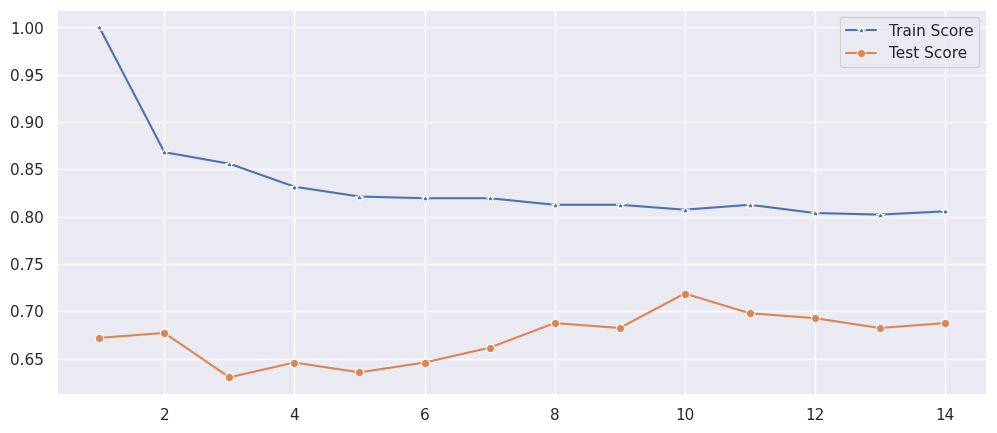

In [ ]:
import seaborn as sns
sns.set()
plt.figure(figsize=(12,5))
p = sns.lineplot(x=range(1,15),y=train_scores,marker='*',label='Train Score')
p = sns.lineplot(x=range(1,15),y=test_scores,marker='o',label='Test Score')

The best result was obtained at k = 10 hence, 10 will be used for the final KNN classifier model.

In [ ]:
#Setup a knn classifier with k neighbors
knn = KNeighborsClassifier(10)

knn.fit(X_train,y_train)
knn.score(X_test,y_test)

0.71875

**Confusion Matrix**

In [ ]:
#prediction
pred = knn.predict(X_test)
pred_proba = knn.predict_proba(X_test)[:,1]


Text(0.5, 1.0, 'Confusion Matrix (Stacking)')

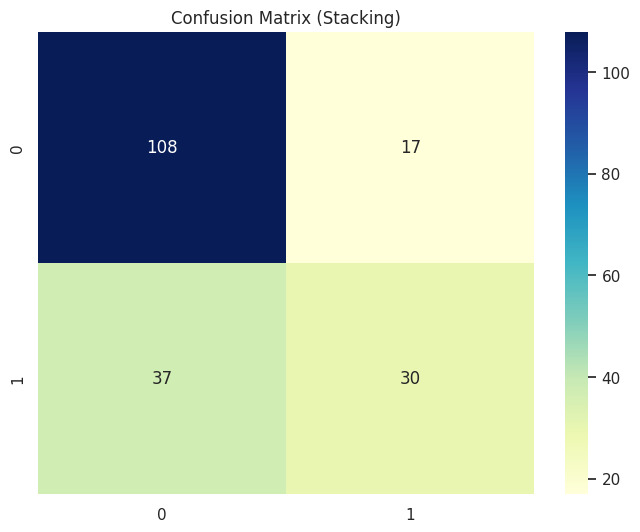

In [ ]:
from sklearn.metrics import confusion_matrix

plt.figure(figsize=(8, 6))

y_pred = knn.predict(X_test)
confusion = confusion_matrix( y_test, y_pred)
ax = sns.heatmap(confusion, cmap = 'YlGnBu',annot = True, fmt='d')
ax.set_title('Confusion Matrix (Stacking)')

In [ ]:
from sklearn.metrics import roc_curve
y_pred_proba = knn.predict_proba(X_test)[:,1]
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)

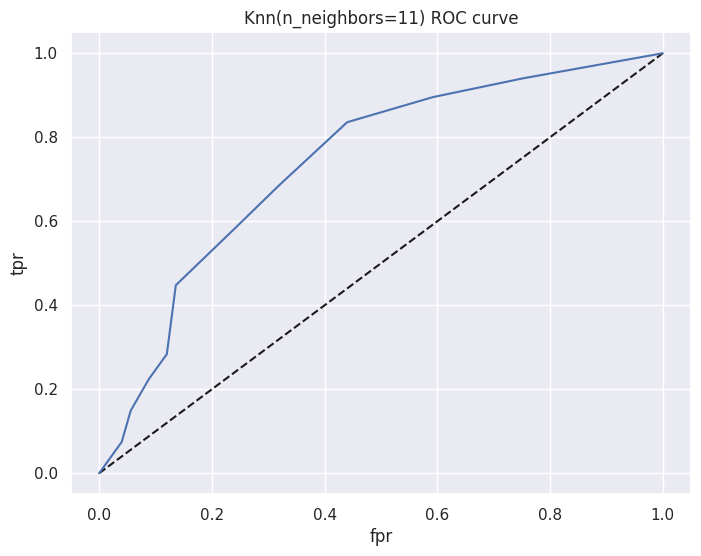

In [ ]:
plt.figure(figsize=(8, 6))
plt.plot([0,1],[0,1],'k--')
plt.plot(fpr,tpr, label='Knn')
plt.xlabel('fpr')
plt.ylabel('tpr')
plt.title('Knn(n_neighbors=11) ROC curve')
plt.show()

In [ ]:
from sklearn.metrics import classification_report

print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.74      0.86      0.80       125
           1       0.64      0.45      0.53        67

    accuracy                           0.72       192
   macro avg       0.69      0.66      0.66       192
weighted avg       0.71      0.72      0.70       192



In [ ]:
#import GridSearchCV
from sklearn.model_selection import GridSearchCV
#In case of classifier like knn the parameter to be tuned is n_neighbors
param_grid = {'n_neighbors':np.arange(1,50)}
knn = KNeighborsClassifier()
knn_cv= GridSearchCV(knn,param_grid,cv=5)
knn_cv.fit(X,y)

print("Best Score:" + str(knn_cv.best_score_))
print("Best Parameters: " + str(knn_cv.best_params_))

Best Score:0.753968253968254
Best Parameters: {'n_neighbors': 34}
